# Calculate the read distance and pairwise contact distance

Input juicematrix file and hic-c matrix file， anlaysis reads cover distance and adjacent and non-adjacent pairwise contact diastance

In [1]:
import pandas as pd
import numpy as np
import gc
import datatable as dt
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['pdf.fonttype'] = 42
sns.set_color_codes("muted")
import random
import matplotlib.pyplot as plt
from matplotlib import rcParams 
rcParams['pdf.fonttype'] = 42 # True font
rcParams['font.family'] =  'Arial' # font Arial
rcParams['font.size'] =  8  
rcParams['grid.linewidth'] =  0.5 
rcParams['lines.color'] = 'b' 
rcParams['lines.linewidth'] = 1 
rcParams['lines.markersize'] = 3
rcParams['lines.markeredgewidth'] = 0 # set Marker with no edgelines
rcParams['axes.linewidth'] = 0.5

rcParams['axes.titlesize'] = 12
rcParams['axes.labelsize'] = 8
rcParams['xtick.labelsize'] = 6
rcParams['ytick.labelsize'] = 6
rcParams['legend.fontsize'] = 6
rcParams['legend.title_fontsize'] = 8


In [5]:
# Loading
def LoadMatrixReader(filename, Chunksize, colnamelist, usecols, skip_rownum=0, sepstr="\t"):
    if skip_rownum == 0: 
        file_reader = pd.read_table(filename, sep=sepstr,
                                    chunksize=Chunksize, iterator=True,
                                    header=None, index_col=None, names = colnamelist, usecols = usecols)
    else:
        file_reader = pd.read_table(filename, sep=sepstr,
                            chunksize=Chunksize, iterator=True,
                            header=None, index_col=None, names = colnamelist, usecols = usecols, skiprows = skip_rownum)
    return (file_reader)

# Subsampling df
def SubsampleDF(df, subrate=0.05):
    dfsize = len(df)
    ramlist = random.sample( range(0, dfsize), int(dfsize*subrate)  )
    return(df.iloc[ramlist])
    

# Distance
def CalculateDistance(df):
    P = df.chr1 == df.chr2
    print("Loading %d records, and %d passed"%(len(df), sum(P)) )
    df = df.loc[P, :]
    df.loc[:, "distance"] = abs( df["pos1"].values - df["pos2"].values )
    df = df.loc[:, ["read_name", "distance"] ]
    return(df)

# Distance for hic pairs matrix
def HiC_CalculateDistance(df):
    P = df.chr1 == df.chr2
    print("Loading %d records, and  %d passed"%(len(df), sum(P)) )
    df = df.loc[P, :]
    df.loc[:, "distance"] = abs( df["pos1"].values - df["pos2"].values )
    df.loc[:, "Fragnum"] = 2
    df = df.loc[:, ["Fragnum", "distance"] ]
    return(df)


# Calculate fragments
def FragmentCount(df, Fragmentcount):
    df["Fragnum"] = 2 # 预设
    # del no fragment info reads
    P = df.read_name.isin( Fragmentcount.index.to_list() )
    df_filter = df.loc[P, :]
    print("Filter out %d records"%(len(df) - len(df_filter) )  )
    df = None
    df_filter.loc[:, "Fragnum"] = df_filter["read_name"].apply(lambda x : Fragmentcount.loc[x])
    return(df_filter)

# The max distance
def ReadMaxDistance(df):
    df = df.sort_values(by=["read_name", "distance"], axis=0, ascending=False)
    # keep the max distance
    df_maxdist = df.drop_duplicates(subset="read_name", keep='first')
    df_maxdist = df_maxdist.loc[:, ["Fragnum", "distance"]]
    return(df_maxdist)

In [3]:
# Fragment count
filename = "/data1/ZJY/Pore-C/Analysis/NA12878/Merge_NA12878/vdFAnnotation/Merge_Align_Fragment_RvdF_5Reps.csv"
print("Loading %s"%filename)
usecols = ["read_name","chrom"]
Chunksize = 5000000
VDF_DF_reader = pd.read_table(filename, sep=",",
                       chunksize=Chunksize, iterator=True,
                        header=0, index_col=None,  usecols = usecols)
Fragment_list =  []
for df in VDF_DF_reader:
    try:
        Fragment_list.append(df)
        df = None
    except Exception as e:
        print(repr(e))
        continue
VDF_DF = pd.concat(Fragment_list)
Fragment_list = None
## fragment count
Fragmentcount = VDF_DF.groupby(by="read_name", as_index=True)["chrom"].count()
VDF_DF = None
del(VDF_DF)
gc.collect()

Loading /data1/ZJY/Pore-C/Analysis/NA12878/Merge_NA12878/vdFAnnotation/Merge_Align_Fragment_RvdF_5Reps.csv


0

In [6]:
# HiC pairs matrix
hicfile = "/data1/ZJY/Pore-C/Analysis/HiC_NA12878/DpnII_Rao2014/JuiceMatrix/pairs.txt"
Chunksize = 5000000
colnamelist = ["read_name", "chr1", "pos1", "chr2", "pos2", "str1", "str2", "type","mapq1", "mapq2"]
usecols = ["read_name", "chr1", "pos1", "chr2", "pos2"]
file_reader = LoadMatrixReader(hicfile, Chunksize, colnamelist, usecols, 2, "\t")
HiC_Dlist =  []
for df in file_reader :
    df = SubsampleDF(df, 0.1)
    try:
        df = HiC_CalculateDistance(df)
        HiC_Dlist.append( df.loc[:, ["Fragnum", "distance"] ] )
        df = None
        gc.collect()
    except Exception as e:
        print(repr(e))
        continue
HiC_Dist_df = pd.concat(HiC_Dlist)
HiC_Dlist = None
gc.collect()

Loading 500000 records, and  500000 passed
Loading 500000 records, and  500000 passed
Loading 500000 records, and  500000 passed
Loading 500000 records, and  500000 passed
Loading 500000 records, and  500000 passed
Loading 500000 records, and  500000 passed
Loading 500000 records, and  16109 passed


/home/zyserver/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/zyserver/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/zyserver/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

Loading 500000 records, and  0 passed
ValueError('cannot set a frame with no defined index and a scalar')
Loading 500000 records, and  215782 passed
Loading 500000 records, and  500000 passed
Loading 500000 records, and  500000 passed
Loading 500000 records, and  452171 passed
Loading 500000 records, and  192659 passed
Loading 500000 records, and  500000 passed
Loading 500000 records, and  500000 passed
Loading 500000 records, and  491357 passed
Loading 500000 records, and  177832 passed
Loading 500000 records, and  500000 passed
Loading 500000 records, and  500000 passed
Loading 500000 records, and  478670 passed
Loading 500000 records, and  233055 passed
Loading 500000 records, and  500000 passed
Loading 500000 records, and  346889 passed
Loading 500000 records, and  500000 passed
Loading 500000 records, and  411556 passed
Loading 500000 records, and  412741 passed
Loading 500000 records, and  500000 passed
Loading 500000 records, and  340952 passed
Loading 500000 records, and  50000

0

In [7]:
# Reads cover distance
maxDistancelist = []
juicefile = "/data1/ZJY/Pore-C/Analysis/NA12878/Merge_NA12878/juiceMatrix/juice_matrix_sort.txt"
Chunksize = 5000000
colnamelist = ["read_name", "str1", "chr1", "pos1","frag1","str2", "chr2", "pos2","frag2","mapq1", "mapq2"]
usecols = ["read_name", "chr1", "pos1", "chr2", "pos2"]
file_reader = LoadMatrixReader(juicefile, Chunksize, colnamelist, usecols, 0, "\t")
#Ncount = 0
for df in file_reader:
    df = SubsampleDF(df, 0.05)
    try:
        df = CalculateDistance(df)
        df = FragmentCount(df, Fragmentcount)
        df_maxdist = ReadMaxDistance(df)
        maxDistancelist.append(df_maxdist)
        df, df_maxdist = None, None
        gc.collect()
    except Exception as e:
        print(repr(e))
        continue
    #if Ncount >= 10:
    #    break
    #Ncount += 1
maxDist_df = pd.concat(maxDistancelist) 
maxDistancelist = None
gc.collect()

Loading 250000 records, and 250000 passed
Filter out 39464 records
Loading 250000 records, and 250000 passed
Filter out 38740 records
Loading 250000 records, and 250000 passed
Filter out 39195 records
Loading 250000 records, and 250000 passed
Filter out 39211 records
Loading 250000 records, and 250000 passed
Filter out 39296 records
Loading 250000 records, and 250000 passed
Filter out 39327 records
Loading 250000 records, and 250000 passed
Filter out 39049 records
Loading 250000 records, and 250000 passed
Filter out 39260 records
Loading 250000 records, and 250000 passed
Filter out 39038 records
Loading 250000 records, and 250000 passed
Filter out 38904 records
Loading 250000 records, and 250000 passed
Filter out 38901 records
Loading 250000 records, and 250000 passed
Filter out 39641 records
Loading 250000 records, and 250000 passed
Filter out 39036 records
Loading 250000 records, and 250000 passed
Filter out 39076 records
Loading 250000 records, and 250000 passed
Filter out 38908 rec

Filter out 40026 records
Loading 250000 records, and 250000 passed
Filter out 40665 records
Loading 250000 records, and 74217 passed
Filter out 12162 records
Loading 250000 records, and 0 passed
Filter out 0 records
Loading 250000 records, and 0 passed
Filter out 0 records
Loading 250000 records, and 0 passed
Filter out 0 records
Loading 250000 records, and 199075 passed
Filter out 31251 records
Loading 250000 records, and 250000 passed
Filter out 39371 records
Loading 250000 records, and 250000 passed
Filter out 38839 records
Loading 250000 records, and 250000 passed
Filter out 39369 records
Loading 250000 records, and 250000 passed
Filter out 38788 records
Loading 250000 records, and 250000 passed
Filter out 39310 records
Loading 250000 records, and 250000 passed
Filter out 39236 records
Loading 250000 records, and 64656 passed
Filter out 10183 records
Loading 250000 records, and 0 passed
Filter out 0 records
Loading 250000 records, and 0 passed
Filter out 0 records
Loading 250000 re

Loading 250000 records, and 250000 passed
Filter out 40619 records
Loading 250000 records, and 232839 passed
Filter out 37231 records
Loading 250000 records, and 0 passed
Filter out 0 records
Loading 250000 records, and 0 passed
Filter out 0 records
Loading 250000 records, and 162258 passed
Filter out 25781 records
Loading 250000 records, and 250000 passed
Filter out 39888 records
Loading 250000 records, and 250000 passed
Filter out 40458 records
Loading 250000 records, and 250000 passed
Filter out 39934 records
Loading 250000 records, and 250000 passed
Filter out 39401 records
Loading 250000 records, and 250000 passed
Filter out 40083 records
Loading 250000 records, and 250000 passed
Filter out 40147 records
Loading 250000 records, and 250000 passed
Filter out 39661 records
Loading 250000 records, and 250000 passed
Filter out 39763 records
Loading 250000 records, and 250000 passed
Filter out 40325 records
Loading 250000 records, and 250000 passed
Filter out 40135 records
Loading 25000

0

In [42]:
# Reads non-adj distance
Chrlist = ["chr%d"%i for i in range(1,22+1) ]
Chrlist.append("chrX")
Distancelist= []
for chrID in Chrlist:
    juicefile = "/data2/HJL/%s.nonadj.matrix.txt"%chrID
    print("Loading %s"%juicefile)
    Chunksize = 5000000
    colnamelist = ["read_name", "str1", "chr1", "pos1","frag1","str2", "chr2", "pos2","frag2","mapq1", "mapq2"]
    usecols = ["read_name", "chr1", "pos1", "chr2", "pos2"]
    file_reader = LoadMatrixReader(juicefile, Chunksize, colnamelist, usecols, 0, " ")

    Distancelist= []
    for df in file_reader :
        #df = SubsampleDF(df, 0.05)
        try:
            df = CalculateDistance(df)
            df = FragmentCount(df, Fragmentcount)
            Distancelist.append( df.loc[:, ["Fragnum", "distance"] ] )
            df = None
            gc.collect()
        except Exception as e:
            print(repr(e))
            continue
NADist_df = pd.concat(Distancelist)
Distancelist = None
gc.collect()

Loading /data2/HJL/chr1.nonadj.matrix.txt
Loading 5000000 records, and 5000000 passed
Filter out 0 records
Loading 5000000 records, and 5000000 passed
Filter out 0 records
Loading 5000000 records, and 5000000 passed
Filter out 0 records
Loading 5000000 records, and 5000000 passed
Filter out 0 records
Loading 5000000 records, and 5000000 passed
Filter out 0 records
Loading 5000000 records, and 5000000 passed
Filter out 0 records
Loading 5000000 records, and 5000000 passed
Filter out 0 records
Loading 5000000 records, and 5000000 passed
Filter out 0 records
Loading 5000000 records, and 5000000 passed
Filter out 0 records
Loading 5000000 records, and 5000000 passed
Filter out 0 records
Loading 5000000 records, and 5000000 passed
Filter out 0 records
Loading 3438822 records, and 3438822 passed
Filter out 0 records
Loading /data2/HJL/chr2.nonadj.matrix.txt
Loading 5000000 records, and 5000000 passed
Filter out 0 records
Loading 5000000 records, and 5000000 passed
Filter out 0 records
Loadin

Filter out 0 records
Loading /data2/HJL/chr16.nonadj.matrix.txt
Loading 5000000 records, and 5000000 passed
Filter out 0 records
Loading 5000000 records, and 5000000 passed
Filter out 0 records
Loading 5000000 records, and 5000000 passed
Filter out 0 records
Loading 4411113 records, and 4411113 passed
Filter out 0 records
Loading /data2/HJL/chr17.nonadj.matrix.txt
Loading 5000000 records, and 5000000 passed
Filter out 0 records
Loading 5000000 records, and 5000000 passed
Filter out 0 records
Loading 5000000 records, and 5000000 passed
Filter out 0 records
Loading 5000000 records, and 5000000 passed
Filter out 0 records
Loading 19671 records, and 19671 passed
Filter out 0 records
Loading /data2/HJL/chr18.nonadj.matrix.txt
Loading 5000000 records, and 5000000 passed
Filter out 0 records
Loading 5000000 records, and 5000000 passed
Filter out 0 records
Loading 5000000 records, and 5000000 passed
Filter out 0 records
Loading 870992 records, and 870992 passed
Filter out 0 records
Loading /da

0

In [9]:
# Reads adj distance
Distancelist= []
for chrID in Chrlist:
    
    juicefile = "/data2/HJL/%s.adj.matrix.txt"%chrID
    Chunksize = 5000000
    colnamelist = ["read_name", "str1", "chr1", "pos1","frag1","str2", "chr2", "pos2","frag2","mapq1", "mapq2"]
    usecols = ["read_name", "chr1", "pos1", "chr2", "pos2"]
    file_reader = LoadMatrixReader(juicefile, Chunksize, colnamelist, usecols, 0, " ")

    for df in file_reader :
        df = SubsampleDF(df, 0.05)
        try:
            df = CalculateDistance(df)
            df = FragmentCount(df, Fragmentcount)
            Distancelist.append( df.loc[:, ["Fragnum", "distance"] ] )
            df = None
            gc.collect()
        except Exception as e:
            print(repr(e))
            continue
ADJDist_df = pd.concat(Distancelist)
Distancelist = None
gc.collect()

Loading 250000 records, and 250000 passed
Filter out 0 records
Loading 250000 records, and 250000 passed
Filter out 0 records
Loading 250000 records, and 250000 passed
Filter out 0 records
Loading 250000 records, and 250000 passed
Filter out 0 records
Loading 250000 records, and 250000 passed
Filter out 0 records
Loading 10509 records, and 10509 passed
Filter out 0 records
Loading 250000 records, and 250000 passed
Filter out 0 records
Loading 250000 records, and 250000 passed
Filter out 0 records
Loading 250000 records, and 250000 passed
Filter out 0 records
Loading 250000 records, and 250000 passed
Filter out 0 records
Loading 250000 records, and 250000 passed
Filter out 0 records
Loading 16079 records, and 16079 passed
Filter out 0 records
Loading 250000 records, and 250000 passed
Filter out 0 records
Loading 250000 records, and 250000 passed
Filter out 0 records
Loading 250000 records, and 250000 passed
Filter out 0 records
Loading 250000 records, and 250000 passed
Filter out 0 reco

0

In [19]:
def DistanceAccumulation(Dist_Serias, keystr, numbers=50000):
    F_dist = Dist_Serias.values.copy()
    F_dist = F_dist[F_dist>=1000] # Trim 1kb
    # < 1000bp  as 10kb
    mindist = 10000
    F_dist[F_dist<=10000] = mindist 
    Median_dict[keystr] = np.median(F_dist) # Calclulate Median
    x = np.linspace(min(F_dist), max(F_dist), num=numbers)
    F_dist = pd.Series(F_dist) # transfrom to series and count values
    countFreq = F_dist.value_counts(normalize=True, sort=False, bins = numbers ).to_numpy() 
    y = np.cumsum(countFreq)
    print("%s Median: %.0f; Accumulation ratio(<%d) : %.2f"%(keystr, Median_dict[keystr] ,mindist, y[0]) )
    ECDFx_dict[keystr], ECDFy_dict[keystr] = x, y
    return

def DistanceAccumulation2(Dist_Serias, keystr):
    '''
    Distance accumulation
    mindistance, maxdistance
    trim maxdistance
    v2 # 50000 
    '''
    F_dist = Dist_Serias.values.copy()
    # min distance 10kb, max distance 200Mb
    mindist, maxdist = 10**4, 200*10**6
    F_dist = F_dist[F_dist>=1000] # Trim 1kb
    F_dist[F_dist<=mindist] = mindist
    F_dist = F_dist[F_dist<=maxdist] # Trim maxdist
    
    Median_dict[keystr] = np.median(F_dist) # Calclulate Median
    # set max distance, insert one max distance
    F_dist = np.insert(F_dist, 1, maxdist)
    x = np.linspace(min(F_dist), max(F_dist), num= 50000 )
    # binsize
    #binsize = 10**4
    #F_dist = np.divide(F_dist,binsize).astype("int") * binsize
    F_dist = pd.Series(F_dist) # transfrom to series and count values
    countFreq = F_dist.value_counts(normalize=True, sort=False, bins = 50000 ).to_numpy()
    y = np.cumsum(countFreq)
    print("%s Median: %.0f; Accumulation ratio(<%d) : %.2f"%(keystr, Median_dict[keystr] ,mindist, y[0]) )
    ECDFx_dict[keystr], ECDFy_dict[keystr] = x, y
    return


# Decade curve
from scipy.interpolate import interp1d, splrep,splev
def smoothline1(x_array, y_array, sbins=50):
    x = np.log10(x_array)
    y = np.log10( y_array + (10**-10) )
    ip = interp1d(x,y)
    xi = np.linspace(x.min(),x.max(),sbins)
    yi = ip(xi)
    tcl = splrep(xi,yi,s=1)
    xs = np.linspace(x.min(), x.max(), sbins*2)
    ys = splev(xs, tcl)
    xs = np.power(10,xs)
    ys = np.power(10,ys)
    return(xs, ys)

def DistanceDecaye(Dist_Serias, keystr):
    F_dist = Dist_Serias.values.copy()
    # < 1000bp  as 10kb
    F_dist[F_dist<=10000] = 10000
    # log scale 
    #log_dist = pd.Series( np.log10(F_dist) )
    #x = np.linspace(min(log_dist), max(log_dist), num=5000)
    #countFreq = log_dist.value_counts(normalize=True, sort=False, bins = 5000 ).to_numpy() 
    x = np.linspace(min(F_dist), max(F_dist), num=5000)
    F_dist = pd.Series(F_dist) # transfrom to series and count values
    countFreq = F_dist.value_counts(normalize=True, sort=False, bins = 5000 ).to_numpy() 
    DecayX_dict[keystr], DecayY_dict[keystr] = x, countFreq
    return

def DistanceDecaye1(Dist_Serias, keystr):
    F_dist = Dist_Serias.values.copy()
    # min distance 10kb, max distance 200Mb
    mindist, maxdist = 10**4, 100*10**6
    F_dist = F_dist[F_dist>=1000] # Trim 1kb
    F_dist[F_dist<=mindist] = mindist
    F_dist = F_dist[F_dist<=maxdist] # Trim maxdist
    # set max distance, insert one max distance
    F_dist = np.insert(F_dist, 1, maxdist)
    # binsize
    binsize = 10**4
    F_dist = np.divide(F_dist,binsize).astype("int") * binsize
    F_dist = pd.Series(F_dist) # transfrom to series and count values
    countFreq = F_dist.value_counts(normalize=True, sort=False)
    DecayX_dict[keystr], DecayY_dict[keystr] = countFreq.index.values, countFreq.values
    return

def DistanceDecaye2(Dist_Serias, keystr):
    F_dist = Dist_Serias.values.copy()
    F_dist = F_dist[F_dist>=1000] # Trim 1kb
    # min distance 10kb, max distance 100Mb
    mindist, maxdist = 10**4, 100*10**6
    F_dist[F_dist<=mindist] = mindist
    F_dist = F_dist[F_dist<maxdist] # Trim maxdist
    # set max distance, insert one max distance
    F_dist = np.insert(F_dist, 1, maxdist)
    # binsize
    #binsize = 10**4
    #F_dist = np.divide(F_dist,binsize).astype("int") * binsize
    F_dist = pd.Series(F_dist) # transfrom to series and count values
    x = np.linspace(min(F_dist), max(F_dist), num=5000)
    countFreq = F_dist.value_counts(normalize=True, sort=False, bins = 5000 ).to_numpy() 
    DecayX_dict[keystr], DecayY_dict[keystr] = x, countFreq
    return

# N50 distance calculate
def N50Distance(values):
    values = list( np.sort(values) )
    values = values[::-1]
    sumvalue = sum( values )
    cumlen = 0
    for vi in values:
        cumlen += vi
        if cumlen >= 0.5*sumvalue:
            N50 = vi
            break
    return(N50)

Hi-C Median: 209089; Accumulation ratio(<10000) : 0.20
Read_cover_dist Median: 808145; Accumulation ratio(<10000) : 0.10
Adj_dist Median: 235624; Accumulation ratio(<10000) : 0.20
NonAdj_dist Median: 1252130; Accumulation ratio(<10000) : 0.06


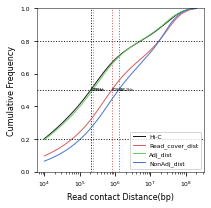

In [43]:
## Cumulative Curve plot
ECDFy_dict = {}
ECDFx_dict = {}
Median_dict = {}

# HiC Dist
DistanceAccumulation2(HiC_Dist_df.distance, "Hi-C")
# allReads Dist read cover
DistanceAccumulation2(maxDist_df.distance, "Read_cover_dist")
# adj Dist
DistanceAccumulation2(ADJDist_df.distance, "Adj_dist")
# non-adj Dist
DistanceAccumulation2(NADist_df.distance, "NonAdj_dist")

fig, ax = plt.subplots(figsize=(3, 3))
Read_Types = ["Hi-C", "Read_cover_dist", "Adj_dist", "NonAdj_dist"]
Colors = ["k",  "r",  "g", "b"]

for color, rtype in zip(Colors, Read_Types):
    x, y = ECDFx_dict[rtype], ECDFy_dict[rtype]
    Datadf = pd.DataFrame({"x":x, "y":y})
    Datadf = Datadf.sort_values("x", ignore_index=True)
    plt.plot(Datadf.x, Datadf.y, linewidth=1,  label=rtype, color=color)
    # 50% overlap line
    P = np.searchsorted( Datadf.y, 0.5)
    distance50 = Datadf.iloc[P]["x"]
    plt.axvline(x = distance50 , ls=":", c=color, linewidth=1)
    plt.text(distance50, 0.5, "%.0fkb"%(Median_dict[rtype]/1000) , fontsize=4 )
        
YThreds = [0.2, 0.5, 0.8]
for ythred in YThreds:
    plt.axhline(y = ythred, ls=":", c="k", linewidth=1) 
    
plt.legend()
plt.ylim([0, 1])
plt.xscale('log')
ax.set_xlabel("Read contact Distance(bp)")
ax.set_ylabel("Cumulative Frequency")
#plt.show()
plt.savefig("Cumulative_Contact_distance_0530_median-v2.pdf")

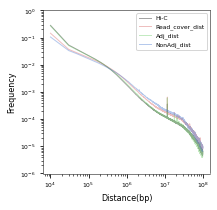

In [44]:
## Decaye Curve plot for LRMF Read cover distance 
DecayX_dict = {}
DecayY_dict = {}
# HiC Dist
DistanceDecaye2(HiC_Dist_df.distance, "Hi-C")
# allReads Dist read cover
DistanceDecaye2(maxDist_df.distance, "Read_cover_dist")
# adj Dist
DistanceDecaye2(ADJDist_df.distance, "Adj_dist")
# non-adj Dist
DistanceDecaye2(NADist_df.distance, "NonAdj_dist")

Read_Types = ["Hi-C", "Read_cover_dist", "Adj_dist", "NonAdj_dist"]
Colors = ["k",  "r",  "g", "b"]
fig, ax = plt.subplots(figsize=(3, 3))

for color, rtype in zip(Colors, Read_Types):
    x, y = DecayX_dict[rtype], DecayY_dict[rtype]
    Datadf = pd.DataFrame({"x":DecayX_dict[rtype], "y":DecayY_dict[rtype]})
    Datadf = Datadf.sort_values("x", ignore_index=True)
    plt.plot(Datadf.x, Datadf.y, linewidth=1,  label=rtype, color=color, alpha=0.4)
    #plt.plot(xs, ys, linewidth=1, label=rtype, color=color)
    #plt.xlim([20000, 10**8.5])
    plt.xscale('log')
    plt.yscale('log')
plt.legend()
plt.ylim([10**-6, 1])
ax.set_xlabel("Distance(bp)")
ax.set_ylabel("Frequency")
#plt.show()
plt.savefig("DecayCureve_Contact_distance_0530_raw-v2.pdf")

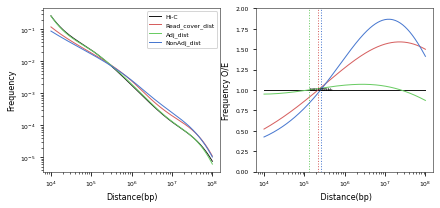

In [50]:
Read_Types = ["Hi-C", "Read_cover_dist", "Adj_dist", "NonAdj_dist"]
Colors = ["k",  "r",  "g", "b"]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3), sharex=True)

for color, rtype in zip(Colors, Read_Types):
    x, y = DecayX_dict[rtype], DecayY_dict[rtype]
    Datadf = pd.DataFrame({"x":DecayX_dict[rtype], "y":DecayY_dict[rtype]})
    Datadf = Datadf.sort_values("x", ignore_index=True)
    xs, ys = smoothline1(Datadf.x, Datadf.y, 500)
    ax[0].plot(xs, ys, linewidth=1, label=rtype, color=color)
    #plt.xlim([20000, 10**8.5])
    plt.xscale('log')
    ax[0].set_yscale('log')
ax[0].legend()
#plt.ylim([10**-6, 1])
ax[0].set_xlabel("Distance(bp)")
ax[0].set_ylabel("Frequency")


for color, rtype in zip(Colors, Read_Types):
    x, y = DecayX_dict[rtype], DecayY_dict[rtype]
    Datadf = pd.DataFrame({"x":DecayX_dict[rtype], "y":DecayY_dict[rtype]})
    Datadf = Datadf.sort_values("x", ignore_index=True)
    xs, ys = smoothline1(Datadf.x, Datadf.y, 100)
    if rtype == "Hi-C":
        ControlY = ys
    ax[1].plot(xs, ys/ControlY, linewidth=1, label=rtype, color=color)
    ## overlap line
    if rtype == "Hi-C":
        ControlY = ys
        continue
    P = np.searchsorted( ys/ControlY, 1.0)
    distance1 = xs[P]
    ax[1].axvline(x = distance1 , ls=":", c=color, linewidth=1)
    ax[1].text(distance1, 1.0, "%.0fkb"%(distance1/1000), fontsize=4 )

    plt.xscale('log')
    #plt.yscale('log')
ax[1].set_ylim([0, 2])
ax[1].set_xlabel(" Distance(bp)")
ax[1].set_ylabel("Frequency O/E")
#plt.show()
plt.savefig("DecayCureve_Contact_distance_0530_OE_v2.pdf")

In [46]:
def ReadsTypeDist(hicdf, distdf, distfun):
    '''
    define lwLRMFs, mdLRMFs, hgLRMFs
    '''
    # HiC Dist
    distfun(hicdf["distance"], "Hi-C")
    #DistanceAccumulation2(hicdf.distance, "Hi-C")
    # Low (2-3), media(4-9), high(>=10)
    distfun(distdf.loc[distdf.Fragnum<=3, "distance"], "lwLRMFs")
    distfun(distdf.loc[(distdf.Fragnum>=4) & (distdf.Fragnum<=9),"distance"], "mdLRMFs")
    distfun(distdf.loc[distdf.Fragnum>=10,"distance"], "hgLRMFs")
    return

def CumulatePlot(Linecolor, Nx, My, Axlist, title):
    Read_Types = ["Hi-C", "lwLRMFs", "mdLRMFs", "hgLRMFs"]
    Lstyles = ["-", "--", "-.", ":"]
    Colors = ["k",Linecolor, Linecolor, Linecolor]
    
    # cumulative 
    for color, ltype, rtype in zip(Colors, Lstyles, Read_Types):
        x, y = ECDFx_dict[rtype], ECDFy_dict[rtype]
        Datadf = pd.DataFrame({"x":x, "y":y})
        Datadf = Datadf.sort_values("x", ignore_index=True)
        Axlist[Nx, My].plot(Datadf.x, Datadf.y, linewidth=1,  label=rtype, color=color, ls=ltype)
        ## 50% line
        P = np.searchsorted( Datadf.y, 0.5)
        distance50 = Datadf.iloc[P]["x"]
        Axlist[Nx, My].axvline(x = distance50 , ls=":", c=color, linewidth=1)  
        Axlist[Nx, My].text(distance50, 0.5, "%.0fkb"%(Median_dict[rtype]/1000) , fontsize=4 )
        
    # thred line
    YThreds = [0.2, 0.5, 0.8]
    for ythred in YThreds:
        Axlist[Nx, My].axhline(y = ythred, ls=":", c="k", linewidth=1) 
    
    Axlist[Nx, My].set_ylim([0, 1])
    Axlist[Nx, My].set_xscale('log')
    Axlist[Nx, My].legend()
    Axlist[Nx, My].set_ylabel("Cumulative Frequency")
    Axlist[Nx, My].set_title(title)
    return
        
    
def DecayPlot(Linecolor, Nx, My, Axlist, title):
    Read_Types = ["Hi-C", "lwLRMFs", "mdLRMFs", "hgLRMFs"]
    Lstyles = ["-", "--", "-.", ":"]
    Colors = ["k",Linecolor, Linecolor, Linecolor]
    
    ## decay plot normal
    for color, ltype, rtype in zip(Colors, Lstyles, Read_Types):
        x, y = DecayX_dict[rtype], DecayY_dict[rtype]
        Datadf = pd.DataFrame({"x":DecayX_dict[rtype], "y":DecayY_dict[rtype]})
        Datadf = Datadf.sort_values("x", ignore_index=True)
        xs, ys = smoothline1(Datadf.x, Datadf.y, 500)
        Axlist[Nx, My].plot(xs, ys, linewidth=1, label=rtype, color=color, ls=ltype)
    Axlist[Nx, My].set_yscale('log')
    Axlist[Nx, My].set_xscale('log')
    Axlist[Nx, My].set_ylim([10**-6, 1])
    Axlist[Nx, My].legend()
    #Axlist[Nx, My].set_xlabel("Distance(bp)")
    Axlist[Nx, My].set_ylabel("Frequency")

    ## observe over control
    for color, ltype, rtype in zip(Colors, Lstyles, Read_Types):
        x, y = DecayX_dict[rtype], DecayY_dict[rtype]
        Datadf = pd.DataFrame({"x":DecayX_dict[rtype], "y":DecayY_dict[rtype]})
        Datadf = Datadf.sort_values("x", ignore_index=True)
        xs, ys = smoothline1(Datadf.x, Datadf.y, 100)
        if rtype == "Hi-C":
            ControlY = ys
        Axlist[Nx+1, My].plot(xs, ys/ControlY, linewidth=1, label=rtype, color=color, ls=ltype)
        ## overlap line
        if rtype == "Hi-C":
            continue
        P = np.searchsorted( ys/ControlY, 1.0)
        try:
            distance1 = xs[P]
            Axlist[Nx+1, My].axvline(x = distance1 , ls=":", c=color, linewidth=1)
            Axlist[Nx+1, My].text(distance1, 1.0, "%.0fkb"%(distance1/1000), fontsize=4 )
        except:
            pass
        
    Axlist[Nx+1, My].set_xscale('log')
    Axlist[Nx+1, My].set_ylim([0, 3])
    Axlist[Nx+1, My].legend()
    Axlist[Nx+1, My].set_xlabel("Contact Distance(bp)")
    Axlist[Nx+1, My].set_ylabel("Frequency O/E")
    return



Hi-C Median: 209089; Accumulation ratio(<10000) : 0.20
lwLRMFs Median: 248040; Accumulation ratio(<10000) : 0.19
mdLRMFs Median: 610222; Accumulation ratio(<10000) : 0.11
hgLRMFs Median: 2154962; Accumulation ratio(<10000) : 0.05
Hi-C Median: 209089; Accumulation ratio(<10000) : 0.20
lwLRMFs Median: 199392; Accumulation ratio(<10000) : 0.22
mdLRMFs Median: 231842; Accumulation ratio(<10000) : 0.20
hgLRMFs Median: 258134; Accumulation ratio(<10000) : 0.18
Hi-C Median: 209089; Accumulation ratio(<10000) : 0.20
lwLRMFs Median: 813651; Accumulation ratio(<10000) : 0.11
mdLRMFs Median: 1068112; Accumulation ratio(<10000) : 0.08
hgLRMFs Median: 1499696; Accumulation ratio(<10000) : 0.05


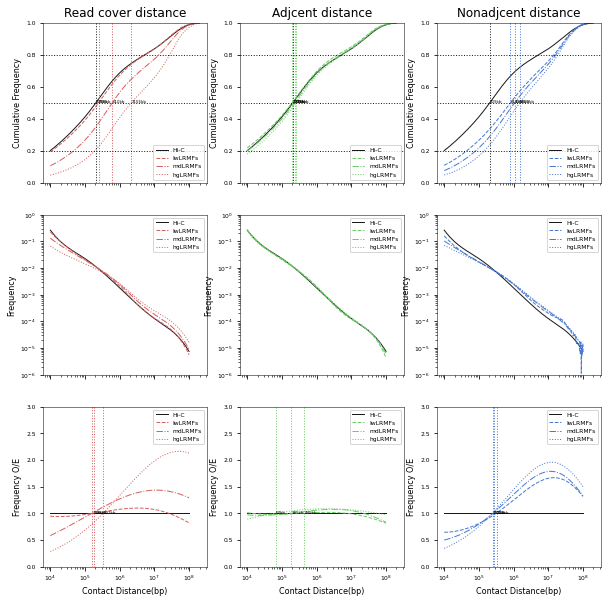

In [47]:
# Plot
fig, Axlist = plt.subplots(nrows=3, ncols=3, figsize=(10, 10), sharex=True)
Linecolor = ["r",  "g", "b"]
Titles = ["Read cover distance", "Adjcent distance", "Nonadjcent distance"]

## Accumulaton plot
Nx = 0
for lc,  My, title, line_df in zip( Linecolor, [0,1,2], Titles, [maxDist_df, ADJDist_df, NADist_df] ):
    ECDFy_dict, ECDFx_dict, Median_dict   = {}, {}, {}
    ReadsTypeDist(HiC_Dist_df, line_df, DistanceAccumulation2)
    CumulatePlot(lc, Nx, My, Axlist, title)


# Decay  plot
Nx = 1
for lc,  My, title, line_df in zip( Linecolor, [0,1,2], Titles, [maxDist_df, ADJDist_df, NADist_df] ):
    ECDFy_dict, ECDFx_dict  = {}, {}
    ReadsTypeDist(HiC_Dist_df, line_df, DistanceDecaye2)
    DecayPlot(lc, Nx, My, Axlist, title)

plt.savefig("Supplementary_contact_distance_9subplots_0530-v2.pdf")    
#plt.show()